In [585]:
from brian2 import *
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

%matplotlib inline

# populations
N = 100  # Total size of population
N_E = int(N * 0)  # pyramidal neurons
N_I = int(N * 1)  # interneurons

# voltage
V_L = -70. * mV # Resting potential
V_thr = -52. * mV  # Threshold for firing
V_reset = -59. * mV  # Resest voltage
V_E = 0 * mV  # Reversal potential excitatory
V_I = -70. * mV  # Reversal potential inhibitory

# refractory period
tau_E = 2. * ms
tau_I = 1. * ms

# external stimuli  
C_ext = 800  # Number of inputs
total_input = int(12000 / C_ext)
rate = total_input * Hz

# Membrane time constants for I and E
tau_m_I = 10 * ms
tau_m_E = 20 * ms

# Conductances, I
g_GABA_I = 4 * nS
g_AMPA_I = 0.3 * nS # 0.3
g_NMDA_I = 0.1 * nS

# Conductances, E
g_GABA_E = 2.5 * nS
g_AMPA_E = 0.19 * nS
g_NMDA_E = 0.06 * nS

# Time constants for GABA
tau_d_GABA = 10 * ms
tau_r_GABA = 0.5 * ms
tau_l_GABA = 5 * ms

# Time constants for AMPA
tau_d_AMPA = 2 * ms
tau_r_AMPA = 0.5 * ms
tau_l_AMPA = 2 * ms

# Time constants for NMDA
tau_d_NMDA = 100 * ms
tau_r_NMDA = 2 * ms
tau_l_NMDA = 1 * ms

# Conductance and Membrane Leak (for correct units)
c_m_I = 20000 * nF #0.2 * nF
g_m_I = 2 * nS #20. * nS
c_m_E = 0.5 * nF #0.5 * nF
g_m_E = 25 * nS #25. * nS

# Normalization Constant
A_t = ( tau_m_I / tau_d_GABA) * \
      (tau_r_GABA / tau_d_GABA ) ** (tau_r_GABA / (tau_d_GABA - tau_r_GABA))
t1, t2 = tau_r_GABA / ms, tau_d_GABA / ms
A1 = -( exp(- A_t / t1)-exp(-A_t / t2))

A_t2 = ( tau_m_I / tau_d_AMPA) * \
      (tau_r_AMPA / tau_d_AMPA ) ** (tau_r_AMPA / (tau_d_AMPA - tau_r_AMPA))

t1, t2 = tau_r_AMPA / ms, tau_d_AMPA / ms
A2 = - (exp(- A_t2 / t1)-exp(-A_t2 / t2))

A1 = 1
A2 = .001

eqs_I = '''
dv/dt = (-g_m_I * (v - V_L) - I_syn) / c_m_I : volt (unless refractory)

I_syn = I_AMPA - I_GABA: amp

I_GABA =  (1 / A1) *  g_GABA_I * (v - V_I) * s_GABA : amp
I_AMPA =  (1 / A2) * g_AMPA_I * (v - V_E) * s_AMPA : amp

ds_GABA/dt = ((tau_r_GABA / tau_d_GABA) ** \
             (tau_d_GABA / (tau_r_GABA - tau_d_GABA))*x-(s_GABA))/tau_d_GABA : 1
dx/dt = -x/tau_r_GABA : 1

ds_AMPA/dt = ((tau_r_AMPA / tau_d_AMPA) ** \
             (tau_d_AMPA / (tau_r_AMPA - tau_d_AMPA))*y-(s_AMPA))/tau_d_AMPA : 1
dy/dt = -y/tau_r_AMPA : 1
'''

eqs_E = '''
dv / dt = (-g_m_E * (v - V_L) - I_syn) / c_m_E : volt (unless refractory)

I_syn = I_GABA + I_AMPA + I_NMDA: amp

I_GABA = g_GABA_E * (v - V_I) * s_GABA : amp
I_AMPA = g_AMPA_E * (v - V_E) * s_AMPA : amp
I_NMDA = g_NMDA_E * (v - V_E) * s_NMDA : amp

ds_GABA / dt = (tau_m_E / (tau_d_GABA - tau_r_GABA)) * 
                (-exp(Gd) / tau_d_GABA + 
                exp(Gr)/ tau_r_GABA) : 1 
dGr / dt = - s_GABA / tau_r_GABA : 1
dGd / dt = - s_GABA / tau_d_GABA : 1

ds_AMPA / dt = (tau_m_E /(tau_d_AMPA - tau_r_AMPA)) * 
               (-exp(Ad)/tau_d_AMPA + 
                exp(Ar)/tau_r_AMPA) : 1 
dAr / dt = - s_AMPA / tau_r_AMPA : 1
dAd / dt = - s_AMPA / tau_d_AMPA : 1

ds_NMDA / dt = (tau_m_E /(tau_d_NMDA - tau_r_NMDA)) * 
               (-exp(Nd)/tau_d_NMDA + 
               exp(Nr)/tau_r_NMDA) : 1  
dNr / dt = - s_NMDA / tau_r_NMDA : 1
dNd / dt = - s_NMDA / tau_d_NMDA : 1          
'''

P_I = NeuronGroup(N_I, eqs_I, threshold='v > V_thr', reset='v = V_reset', refractory=tau_I, method='euler')
# P_E = NeuronGroup(N_E, eqs_E, threshold='v > V_thr', reset='v = V_reset', refractory=tau_E, method='euler')

pre_GABA = '''
x += 1
'''

pre_AMPA= '''
y += 1
'''

pre_NMDA= '''
s_NMDA += 1
'''

C_P_I = PoissonInput(P_I, 'y', C_ext, rate, '1')
# C_P_E = PoissonInput(P_E, 's_AMPA', C_ext, rate, '1')

P_I.v = V_L
C_I_I = Synapses(P_I, P_I, on_pre=pre_GABA, method='euler', delay=tau_l_GABA)
# C_I_E = Synapses(P_I, P_E, on_pre=pre_GABA, method='euler', delay=tau_l_GABA)
C_I_I.connect(condition='i != j', p=0.2)
# C_I_E.connect(p=0.2)

s_I = SpikeMonitor(P_I)
# s_E = SpikeMonitor(P_E[:20])
M = StateMonitor(P_I, ('v', 'x', 'y', 'I_AMPA', 'I_GABA'), record=True)
p_I = PopulationRateMonitor(P_I)
# p_E = PopulationRateMonitor(P_E)

# net = Network(P_I, P_E, C_P_E, C_P_I, C_I_I, C_I_E, s_I, p_I, s_E, p_E)
net = Network(P_I, C_P_I, C_I_I, s_I, p_I, M)
net.run(4.5 * second, report='stdout')

# test_d = np.linspace(1, 10, 10) * ms
# test_r = np.linspace(0.1, 1.1, 10) * ms
# total_rates = np.zeros([len(test_d), len(test_r)])
# net.store()
# p, q = 0, 0
# for td in test_d:
#     for tr in test_r:
# #         for tdd in test_d:
# #             for trr in test_r:
#         net.restore()
# #         tau_d_GABA = td
# #         tau_r_GABA = tr
#         tau_d_AMPA = td
#         tau_r_AMPA = tr

#         net.run(1.5 * second, report='stdout')
#         total_rates[p, q] = s_I.num_spikes/second/N_I
#         p += 1
#     p = 0
#     q += 1

Starting simulation at t=0. s for a duration of 4.5 s
4.5 (100%) simulated in 4s


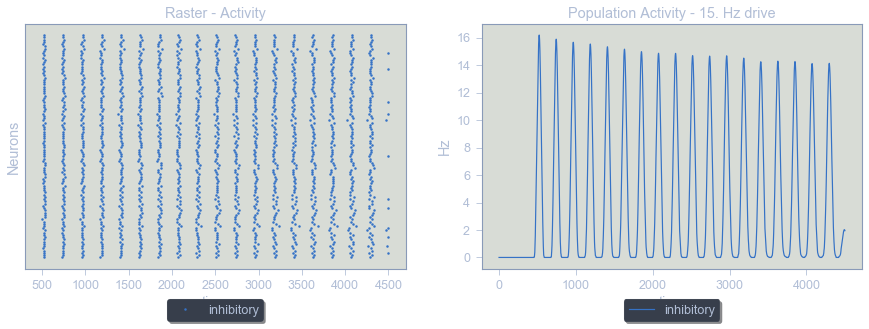

In [586]:
figure(figsize=(15, 5))
subplot(121)
# plt.plot(s_E.t / ms, (s_E.i + 20)*0.025, 'r.', markersize=5, label='exitatory')
plt.plot(s_I.t / ms, s_I.i*0.025, 'b.', markersize=5, label='inhibitory')
title('Raster - Activity')
xlabel('ms')
yticks([])
xlabel('time')
ylabel('Neurons')
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)

subplot(122)
# plt.plot(p_E.t / ms, p_E.smooth_rate(width=25 * ms) / Hz, 'r-', label='exitatory')
plt.plot(p_I.t / ms, p_I.smooth_rate(width=25 * ms) / Hz, 'b-', label='inhibitory')
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')
title('Population Activity - ' + str(rate) + ' drive')
xlabel('ms')
xlabel('time')
ylabel('Hz')
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)

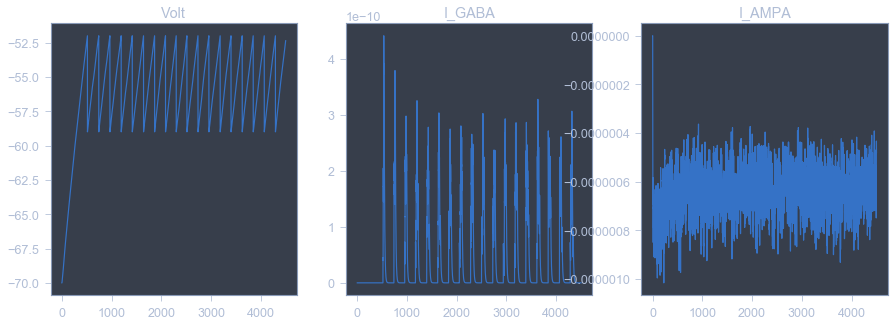

In [587]:
figure(figsize=(15, 5))
subplot(131)
title('voltage')
plot(M.t/ms, M.v[4]/mA)
subplot(132)
title('I_GABA')
plot(M.t/ms, M.I_GABA[0])
subplot(133)
title('I_AMPA')
plot(M.t/ms, M.I_AMPA[0])

In [554]:
A2

-0.2088650125766901